# ChessBot with Neural Network reseach

# Импортирование необходимых библиотек

In [1]:
import numpy as np
import chess
import chess.pgn
import random
import pickle
import itertools
import numpy as np
import tensorflow as tf
import tfdeploy as td
import math
import copy
import io

/home/bokoch/.local/share/virtualenvs/DeepChess-8rGKFGHd/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bokoch/.local/share/virtualenvs/DeepChess-8rGKFGHd/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bokoch/.local/share/virtualenvs/DeepChess-8rGKFGHd/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint

Методы хелперы, для считывания/записования данных с бинарным форматом $.p$.

In [2]:
pieces= {
    'p': 1,
    'P': -1,
    'n': 2,
    'N': -2,
    'b': 3,
    'B': -3,
    'r': 4,
    'R': -4,
    'q': 5,
    'Q': -5,
    'k': 6,
    'K': -6
}

def shortenString(s):
    s = s[:s.rfind(" ")]
    return s;
#Запись доски только одного снимка(фото расположения фигур)
def beautifyFEN(f):
    for i in range(4):
        f = shortenString(f)
    
    toMove = f[-1]
    #кто ходит.
    if toMove == 'w':
        toMove = 7
    else:
        toMove = -7

    f = shortenString(f)

    newf = []

    for char in f:
        if char.isdigit():
            for i in range(int(char)):
                newf.append(0)
        elif char != '/':
            newf.append(pieces[char])
    
    newf.append(toMove)
#    print(f)
#    print(newf)
    return    newf

def bitifyFEN(f):
    arrs = []
    result = []
    # 6 видов фигур с одной и другой стороны
    # двумерная матрица. Где по строке тип фигуры соответствующий s, а по столбцам положение фигуры на доске
    s =     {
        '1' : 0,
        '2' : 1,
        '3' : 2,
        '4' : 3,
        '5' : 4,
        '6' : 5,
        '-1' : 6,
        '-2' : 7,
        '-3' : 8,
        '-4' : 9,
        '-5' : 10,
        '-6' : 11,
        }
             
    for i in range(12):
        arrs.append(np.zeros(64))

    # добавление расстановки фигур на N-ходе.
    for i in range(64):
        c = str(int(f[i]))
        if c != '0':
             #c = s[int(round(c))]
            arrs[s[c]][i] = 1

    for i in range(12):
        result.append(arrs[i])
    
    result = list(itertools.chain.from_iterable(result))
    #f[64] -- чей ход
    if f[64] == -7:
        result.append(1)
    else:
        result.append(0)
    
    return result

def arrToBin(arr):
    first = arr[0]
    second = arr[1]
    r1 = bitifyFEN(first)
    r2 = bitifyFEN(second)
    return [r1,r2]


#bitifyFEN(beautifyFEN('rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR w KQkq e3 0 1'))

Разделение одного большого датасета на $N$ маленьких. Загоняет в бинарники. Для более скорости считывания и обучения.
сука. разбивка не нужна.

In [3]:

# Количество снимков в одном чанке
BATCH_SIZE = 2000
# Общее количество чанков
TOTAL_BATCHES = 10
SPG = 6 

DATASET_NAME = "dataset.pgn"

def get_good_moves(node):
    total = 0
    good = []
    while not node.is_end():
        next_node = node.variation(0)
        x = (node.board().san(next_node.move))
        total = total + 1
        if 'x' not in x: 
            if total > SPG:
                good.append(total)
        node = next_node
    return good


def traverse(node, moves, arr, cur_index):
    total = 1 
    arr_size = len(arr) 
    board = chess.Board()
    while not node.is_end():
        move = next(iter(node.mainline_moves()))
        board.push(chess.Move.from_uci(str(move)))
        if total in moves:
            #Снимок одного хода.
            arr[cur_index] = beautifyFEN(board.fen())
            cur_index = cur_index + 1
            if cur_index == arr_size:
                return cur_index
            moves.remove(total)
            if not moves:
                return cur_index
        next_node = node.variation(0)
        node = next_node
        total = total + 1

    print('bug, shouldnt have reached here')
    return cur_index 


def add_game_data(game, arr, cur_index):
    goodmoves = get_good_moves(game)
    picked = []
    for i in range(SPG):
        if not goodmoves:
            break
        #Добавление рандомного хода игрока.      
        nu = random.choice(goodmoves)
        goodmoves.remove(nu)
        picked.append(nu)
    #Если пустая запись, то возвращаем индекс
    if not picked:
        return cur_index
    cur_index = traverse(game, picked, arr, cur_index)
    return cur_index

def iterate_over_file():
    white_wins = np.zeros((BATCH_SIZE, 65))
    black_wins = np.zeros((BATCH_SIZE, 65))
    total = 0
    runningTotal = 0
    done_bastches = 0
    white_index = 0
    black_index = 0
    
    pgn = open(DATASET_NAME)

    while done_bastches < TOTAL_BATCHES:    
        g = chess.pgn.read_game(pgn)
        if not g:
            break
        # равномерное распределение белых и черных в каждом мини-датасете
        if g.headers["Result"] == "1-0" and white_index < BATCH_SIZE:
            white_index = add_game_data(g, white_wins, white_index)
        elif g.headers["Result"] == "0-1" and black_index < BATCH_SIZE:
            black_index = add_game_data(g, black_wins, black_index)

        total = white_index + black_index
        if (total//BATCH_SIZE == 1):
            filename_volume = 'volume' + str(done_bastches) + '.p'
            print(filename_volume + " " + str(total))
            save_games_to_file(add_labels((white_wins, black_wins)), filename_volume)
            done_bastches = done_bastches + 1
            white_index = 0
            black_index = 0
            
    pgn.close()
    return 0    


def add_labels(arrs):
    x_labels = np.zeros((BATCH_SIZE,2))
    x = np.zeros((BATCH_SIZE,2,65))

    w = arrs[0]
    b = arrs[1]
    # Перемешивание данных для задачи XOR
    np.random.shuffle(w)
    np.random.shuffle(b)

    for i in range(BATCH_SIZE):
        cur = [w[i],b[i]] 
        label = [1,0]
        
        if random.random() > 0.5:            
            cur = [b[i],w[i]] 
            label = [0,1]
        
        x[i] = cur
        x_labels[i] = label
    return (x, x_labels)

def save_games_to_file(arr, name):
    full_data = {"x": arr[0], "x_labels": arr[1]}
    f = open('games/' + name, "wb")
    pickle.dump(full_data, f)
    f.close()



In [4]:
# Количество снимков в одном чанке
BATCH_SIZE = 24
# Общее количество чанков
TOTAL_BATCHES = 4

def iterate_over_file():
    
    white_wins = np.zeros((BATCH_SIZE, 65))
    black_wins = np.zeros((BATCH_SIZE, 65))
    total = 0
    runningTotal = 0
    done_bastches = 0
    white_index = 0
    black_index = 0
    
    pgn = open('d.pgn')

    while done_bastches < TOTAL_BATCHES:
        res = pgn.readline()
        moves = pgn.readline()
        game = chess.pgn.read_game(io.StringIO(moves))
        print(res)
        
        if not game:
            break
        # равномерное распределение белых и черных в каждом мини-датасете
        if res == "[Result \"1-0\"]\n" and white_index < BATCH_SIZE:
            white_index = add_game_data(game, white_wins, white_index)
        elif res == "[Result \"0-1\"]\n" and black_index < BATCH_SIZE:
            black_index = add_game_data(game, black_wins, black_index)
        total = white_index + black_index
        
        if (total//BATCH_SIZE == 1):
            filename_volume = 'volume' + str(done_bastches) + '.p'
            print(filename_volume + " " + str(total))
            save_games_to_file(add_labels((white_wins, black_wins)), filename_volume)
            done_bastches = done_bastches + 1
            white_index = 0
            black_index = 0
            
    pgn.close()
    return 0  

In [5]:
iterate_over_file()

[Result "0-1"]

[Result "0-1"]

[Result "1-0"]

[Result "0-1"]

volume0.p 24
[Result "1-0"]

[Result "0-1"]

[Result "0-1"]

[Result "1-0"]

volume1.p 24
[Result "0-1"]

[Result "0-1"]

[Result "1-0"]

[Result "0-1"]

volume2.p 24
[Result "0-1"]

[Result "1/2-1/2"]

[Result "1-0"]

[Result "0-1"]

[Result "1-0"]

volume3.p 24


0

Загружает данные тестовые с наших разбитых файлов.

Загружаются тестовые данные диапазона выборки.

Start -- начало тома

Finish -- конец тома 

In [6]:
def getTest(input_size, start, finish):
    test = []
    test_l = []

    for i in range(start, finish):
        name = 'games/volume' + str(i) + '.p'
        with io.open(name, 'rb') as test_dataset:
            cur_dict = pickle.load(test_dataset)
            cur_test = cur_dict['x']
            cur_l = cur_dict['x_labels']
            for j in range(len(cur_test)):
                test.append(cur_test[j])
                test_l.append(cur_l[j])

    temp_test = np.zeros((len(test), 2, input_size))
    
    print("Len(test) = " + str(len(test)))
    print("bityfy1 = " + str(len(test[0][0])))
    print("bityfy2 = " + str(len(test[0][1])))
    
    for i in range(len(test)):
        temp_test[i] = [bitifyFEN(test[i][0]), bitifyFEN(test[i][1])]
    # test_l -- чиселки, которые показывают результат партии
    # temp_test -- доска
    return (temp_test, test_l)



Загружает тренировочные данные

In [7]:
def getTrain(input_size, total, volume_size):
    white_wins = np.zeros((total, input_size))
    black_wins = np.zeros((total, input_size))

    for i in range(total//volume_size):
        print("Loading batch number " + str(i))
        with io.open('games/volume' + str(i) + '.p', 'rb') as test_dataset:
            full_data = pickle.load(test_dataset)
            curX = full_data['x']
            curX = np.array(curX)
            curL = full_data['x_labels']
            curL = np.array(curL)
        for j in range(volume_size):
            if curL[j][0] == 1:
                first = bitifyFEN(curX[j][0])    
                second = bitifyFEN(curX[j][1])
            else:
                first = bitifyFEN(curX[j][1])    
                second = bitifyFEN(curX[j][0])

            white_wins[i*volume_size+j] = first
            black_wins[i*volume_size+j] = second 
    
    return (white_wins, black_wins)


# Train

# Константы

In [8]:
#сколько нужно записей
# TOTAL_MLP = 2000

TOTAL_MLP = 24

BS_MLP = 50
EPOCHS_MLP = 201 
RATE_MLP = 0.005
DECAY_MLP = 0.98

BIAS = 0.15

N_INPUT = 769 
ENCODING_1 = 600 
ENCODING_2 = 400 
ENCODING_3 = 200
ENCODING_4 = 100

HIDDEN_1 = 200
HIDDEN_2 = 400 
HIDDEN_3 = 200
HIDDEN_4 = 100 
N_OUT = 2
#количество в томе записей
# VOLUME_SIZE = 2000
VOLUME_SIZE = 24


# Загрузка начальных данных

In [9]:
#Get the data from the game files
validation_test, validation_test_l = getTest(N_INPUT, 3, 4)


Len(test) = 24
bityfy1 = 65
bityfy2 = 65


In [10]:
#снимки белых и черных. ыыыыыыыыыыыыыыыы
white_wins, black_wins = getTrain(N_INPUT, 72, 24)

Loading batch number 0
Loading batch number 1
Loading batch number 2


## Создание переменных баеса и вес переменной

In [11]:
# init
def weight_variable(n_in, n_out):
  cur_dev = math.sqrt(3.0/(n_in+n_out))
  initial = tf.truncated_normal([n_in, n_out], stddev=cur_dev)
  return tf.Variable(initial)

def bias_variable(n_out):
  initial = tf.constant(BIAS, shape=[n_out])
  return tf.Variable(initial)

Многослойный персептрон

In [12]:
def getBatchMLP(start, size):
    global white_wins 
    global black_wins 

    xR = []
    lR = []
    
    for i in range(start,start+size):
        if random.random() > 0.5:
            elem = [white_wins[i], black_wins[i]]
            elem_l = [1,0]
        else:
            elem = [black_wins[i], white_wins[i]]
            elem_l = [0,1]
        xR.append(elem)
        lR.append(elem_l)
    return (xR, lR)

In [22]:
#Переменные игрока -- все фигуры
weights = {
    'e1' : weight_variable(N_INPUT, ENCODING_1),    
    'e2' : weight_variable(ENCODING_1, ENCODING_2),    
    'e3' : weight_variable(ENCODING_2, ENCODING_3),    
    'e4' : weight_variable(ENCODING_3, ENCODING_4),    
    'd1' : weight_variable(ENCODING_4, ENCODING_3),    
    'd2' : weight_variable(ENCODING_3, ENCODING_2),    
    'd3' : weight_variable(ENCODING_2, ENCODING_1),    
    'd4' : weight_variable(ENCODING_1, N_INPUT),    
    'w1' : weight_variable(HIDDEN_1, HIDDEN_2),    
    'w2' : weight_variable(HIDDEN_2, HIDDEN_3),    
    'w3' : weight_variable(HIDDEN_3, HIDDEN_4),    
    'w4' : weight_variable(HIDDEN_4, N_OUT)    
}

biases = {
    'e1' : bias_variable(ENCODING_1),    
    'e2' : bias_variable(ENCODING_2),    
    'e3' : bias_variable(ENCODING_3),    
    'e4' : bias_variable(ENCODING_4),    
    'd1' : bias_variable(ENCODING_3),    
    'd2' : bias_variable(ENCODING_2),    
    'd3' : bias_variable(ENCODING_1),    
    'd4' : bias_variable(N_INPUT),    
    'b1' : bias_variable(HIDDEN_2),    
    'b2' : bias_variable(HIDDEN_3),    
    'b3' : bias_variable(HIDDEN_4),    
    'out' : bias_variable(N_OUT)    
}

Инициализация необходимых переменных

In [23]:
learning_rate = tf.placeholder(tf.float32, shape=[])
x = tf.placeholder(tf.float32, shape=[None, 2, N_INPUT], name="input")
first_board = tf.placeholder(tf.float32, shape=[None, N_INPUT])
second_board = tf.placeholder(tf.float32, shape=[None, N_INPUT])
y_ = tf.placeholder(tf.float32, shape=[None,2])

In [24]:
#матричный слой * вес + биас_перем
def fully_connected(current_layer, weight, bias):
    next_layer = tf.add(tf.matmul(current_layer, weight), bias)
    next_layer = tf.maximum(0.01*next_layer, next_layer)
    return next_layer

def encode(c, weights, biases, level):    
    e1 = fully_connected(c, weights['e1'], biases['e1'])
    if level == 1:
        return e1

    e2 = fully_connected(e1, weights['e2'], biases['e2'])
    if level == 2:
        return e2

    e3 = fully_connected(e2, weights['e3'], biases['e3'])
    if level == 3:
        return e3
    
    e4 = fully_connected(e3, weights['e4'], biases['e4'])
    return e4

def decode(d, weights, biases, level):
    pred  = fully_connected(d, weights['d'+ str(5-level)], biases['d' + str(5-level)])
    return pred

def singleEncode(c, weights, biases, level):
    pred  = fully_connected(c, weights['e'+ str(level)], biases['e' + str(level)])
    return pred

In [25]:
def model(games, weights, biases):
    first_board = games[:,0,:]
    second_board = tf.squeeze(tf.slice(games, [0,1,0], [-1, 1, -1]), squeeze_dims=[1])
    [first_board, second_board] = tf.unstack(games, axis=1)
    
    firstboard_encoding = encode(first_board, weights, biases, 4)
    secondboard_encoding = encode(second_board, weights, biases, 4)
    
    # слои нейросети
    h_1 = tf.concat([firstboard_encoding,secondboard_encoding], 1)
    h_2 = fully_connected(h_1, weights['w1'], biases['b1'])
    h_3 = fully_connected(h_2, weights['w2'], biases['b2'])
    h_4 = fully_connected(h_3, weights['w3'], biases['b3'])
    pred = tf.add(tf.matmul(h_4, weights['w4']), biases['out'], name="output")
    return pred

In [26]:
y = model(x, weights, biases)

In [27]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y, labels=y_))
mlp_train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)
init = tf.initialize_all_variables()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    total_batch = int(TOTAL_MLP/BS_MLP)
    for epoch in range(EPOCHS_MLP):
        cur_rate = RATE_MLP * (DECAY_MLP**epoch)
        white_wins = np.random.permutation(white_wins)
        black_wins = np.random.permutation(black_wins)

        for i in range(total_batch): 
            batch_xs, batch_ys = getBatchMLP(i*BS_MLP, BS_MLP)
            _, cost = sess.run([mlp_train_step, cross_entropy], feed_dict={x: batch_xs, y_:batch_ys, learning_rate: cur_rate})
        print("MLP Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(cost))
        model = td.Model()
        model.add(y, sess)
        model.save("model.pkl")
        if epoch%3 == 2:    
            correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_,1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            v_acc = sess.run(accuracy, feed_dict = {x: validation_test, y_: validation_test_l})
            print("Validation accuracy", "{:.9f}".format(v_acc))



NameError: name 'cost' is not defined

# Игра с нейросетью

In [70]:
model = td.Model("model.pkl")
x = model.get("input")
y = model.get("output")

In [77]:
y?


Type:        NoneType
String form: None
Docstring:   <no docstring>


In [71]:
def netPredict(first, second):
    global model
    global x
    global y

    X = np.zeros((1, 2, N_INPUT))
    X[0][0] = bitifyFEN(beautifyFEN(first.fen()))
    X[0][1] = bitifyFEN(beautifyFEN(second.fen()))

    result = y.eval(feed_dict={x: X})
#     print(first.fen())
#     print("result1")
#     print(result[0][0])
#     print(second.fen())
#     print("result2")
#     print(result[0][1])
    

    if result[0][0] > result [0][1]:
        return (first, second)
    else:
        return (second, first)

In [72]:
def alphabeta(node, depth, alpha, beta):
    if depth == 0:
        return node
    v = 1
    for move in node.legal_moves:
        cur = copy.copy(node)
        cur.push(move)
        if v == 1:
            v = alphabeta(cur, depth-1, alpha, beta) 
        if beta == 1:
            beta = v

        v = netPredict(v, alphabeta(cur, depth-1, alpha, beta))[1]
        beta = netPredict(beta, v)[1] 
        if alpha != -1:
            if netPredict(alpha, beta)[0] == alpha:
                break
    return v 

In [73]:
def computerMove(board, depth):
    alpha = -1
    beta = 1
    v = -1
    for move in board.legal_moves:
        cur = copy.copy(board)
        cur.push(move)
        if v == -1:
            v = alphabeta(cur, depth-1, alpha, beta)
            bestMove = move
            if alpha == -1:
                alpha = v
        else:
            new_v = netPredict(alphabeta(cur, depth-1, alpha, beta), v)[0]
            if new_v != v:
                bestMove = move
                v = new_v
            alpha = netPredict(alpha, v)[0] 

    print(bestMove)    
    board.push(bestMove)
    return board



In [74]:
def playerMove(board):
    while True:
        try:
            move = raw_input("Enter your move \n")
            board.push_san("d6d1")
            break
        except ValueError:
            print("Illegal move, please try again")

    return board

In [75]:
moveTotal = 0;
board = chess.Board()
depth = 2


In [76]:
if moveTotal % 2 == 1:
    board = board.push_san("e5")
else:
    board = computerMove(board, depth)
moveTotal = moveTotal+1
board

AttributeError: 'NoneType' object has no attribute 'eval'

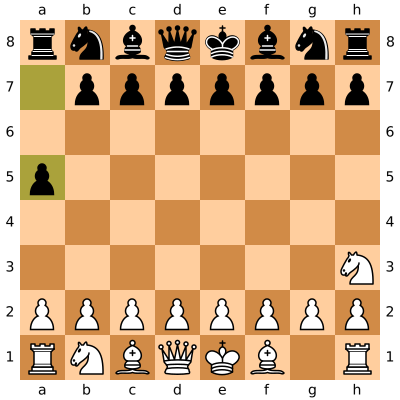

In [35]:
board.push_san("a5")
board

h3g5


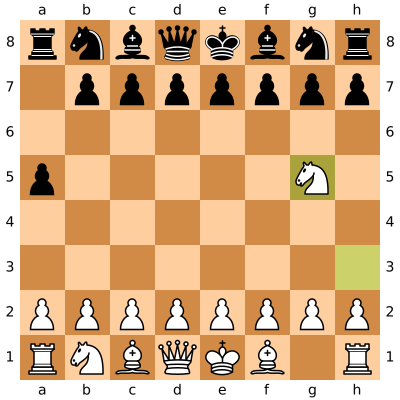

In [36]:
board = computerMove(board, depth)
board

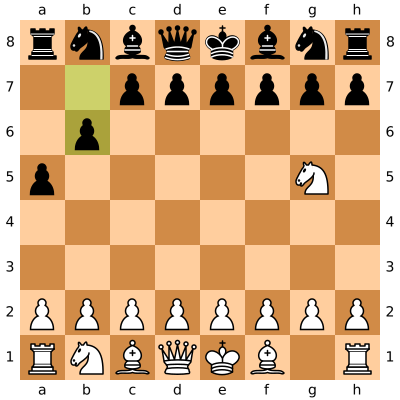

In [38]:
board.push_san("b7b6")
board

g5h7


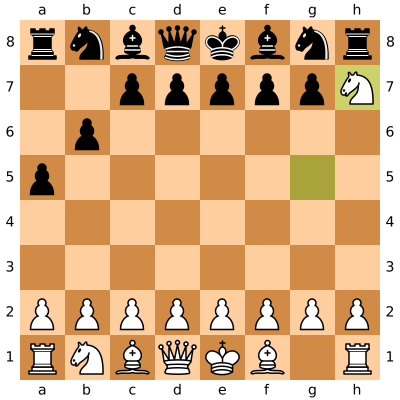

In [39]:
board = computerMove(board, depth)
board

# Литература
1. https://arxiv.org/pdf/1711.09667.pdf(Алгоритм написан по статье)
2. https://www.newyorker.com/science/elements/how-the-artificial-intelligence-program-alphazero-mastered-its-games
3. http://repositorio.ual.es:8080/bitstream/handle/10835/4889/bayeschess.pdf?sequence=1&isAllowed=y
4. https://www.ai.rug.nl/~mwiering/Thesis_Matthia_Sabatelli.pdf